In [1]:
#on importe toutes les bibliothèques
import pandas as pd
import seaborn as sns


import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import datetime
import multiprocessing
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.pipeline import FeatureUnion, Pipeline 
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
import sys
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import  RandomizedSearchCV, cross_val_predict, cross_val_score
from scipy.stats import randint
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
#import xgboost as xgb
import seaborn as sns
import os

In [2]:
train_data=pd.read_csv("data/train.csv")
X_test=pd.read_csv("data/test.csv")

In [3]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


In [4]:
train_data.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,8514.000000,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000
mean,28.827930,224.687617,458.077203,173.729169,311.138778,304.854791
std,14.489021,666.717663,1611.489240,604.696458,1136.705535,1145.717189
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,38.000000,47.000000,76.000000,27.000000,59.000000,46.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000


In [5]:
train_data.isnull().sum()

PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64

In [6]:
train_data.isnull().sum().sum()/12 # calcul de la moyenne des données null

193.66666666666666

In [7]:
#On créer une fonction qui permet de calculer le taux de survit en fonction de l'attribut
def survival_rate(df,feature_name):
    group_count=df[[feature_name,'Transported']].groupby(feature_name).count().rename(columns={'Transported':'Passengers'})
    group_survived= df[[feature_name,'Transported']].groupby(feature_name).sum().rename(columns={'Transported':'Survived'})
    final_df= group_count.merge(group_survived,how="left",left_index=True,right_index=True)
    final_df['Survival_rate']=final_df['Survived']/final_df['Passengers']
    final_df.drop(columns={'Passengers','Survived'},inplace=True)
    return final_df

       Survival_rate
VIP                 
False       0.506332
True        0.381910


<AxesSubplot:xlabel='VIP', ylabel='Survival_rate'>

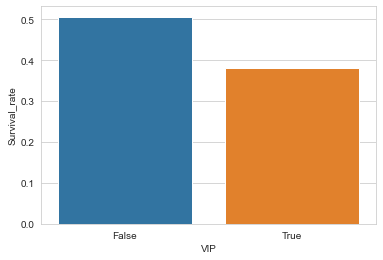

In [26]:
print(survival_rate(train_data, "VIP"))
sns.set_style("whitegrid")
sns.barplot(data=survival_rate(train_data, "VIP").reset_index(),x="VIP",y="Survival_rate")

           Survival_rate
CryoSleep               
False           0.328921
True            0.817583


<AxesSubplot:xlabel='CryoSleep', ylabel='Survival_rate'>

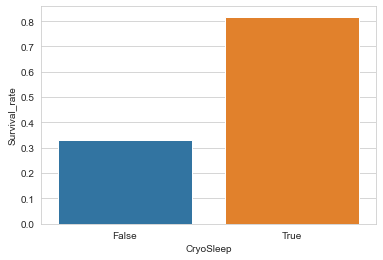

In [27]:
print(survival_rate(train_data, "CryoSleep"))
sns.set_style("whitegrid")
sns.barplot(data=survival_rate(train_data, "CryoSleep").reset_index(),x="CryoSleep",y="Survival_rate")

            Survival_rate
HomePlanet               
Earth            0.423946
Europa           0.658846
Mars             0.523024


<AxesSubplot:xlabel='HomePlanet', ylabel='Survival_rate'>

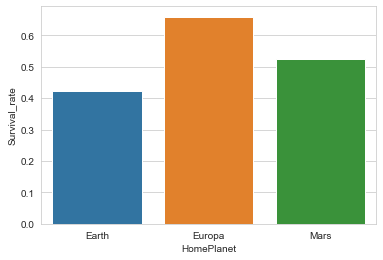

In [28]:
print(survival_rate(train_data, "HomePlanet"))
sns.set_style("whitegrid")
sns.barplot(data=survival_rate(train_data, "HomePlanet").reset_index(),x="HomePlanet",y="Survival_rate")

               Survival_rate
Destination                 
55 Cancri e         0.610000
PSO J318.5-22       0.503769
TRAPPIST-1e         0.471175


<AxesSubplot:xlabel='Destination', ylabel='Survival_rate'>

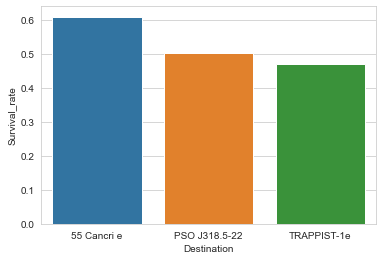

In [29]:
print(survival_rate(train_data, "Destination"))
sns.set_style("whitegrid")
sns.barplot(data=survival_rate(train_data, "Destination").reset_index(),x="Destination",y="Survival_rate")

In [31]:
#on créer une feature qui représente le groupe et une leur numéro du groupe
train_data["group"]=train_data["PassengerId"].str.slice(stop=4)
X_test["group"]=X_test["PassengerId"].str.slice(stop=4)

train_data["number"]=train_data["PassengerId"].str.slice(start=5)
X_test["number"]=X_test["PassengerId"].str.slice(start=5)

train_data['totalTips']=train_data['RoomService']+train_data['FoodCourt']+train_data['ShoppingMall']+train_data['Spa']+train_data['VRDeck']
X_test['totalTips']=X_test['RoomService']+X_test['FoodCourt']+X_test['ShoppingMall']+X_test['Spa']+X_test['VRDeck']

train_data["AgeBucket"] = train_data["Age"] // 15 * 15 #on créer un age bucket
train_data=train_data.merge(train_data.groupby(by=['group']).count().rename(columns={"PassengerId": "numberInGroup"})["numberInGroup"],on="group")

X_test["AgeBucket"] = X_test["Age"] // 15 * 15 #on créer un age bucket
X_test=X_test.merge(X_test.groupby(by=['group']).count().rename(columns={"PassengerId": "numberInGroup"})["numberInGroup"],on="group")

train_data["totalTipsBucket"] = train_data["totalTips"] // 5000 * 5000 #on créer un totalTips bucket
X_test["totalTipsBucket"] = X_test["totalTips"] // 5000 * 5000 #on créer un totalTips bucket


group_wise=train_data[['Cabin','PassengerId']].groupby(['Cabin']).count().rename(columns={"PassengerId":"numberInCabin"})
train_data=pd.merge(train_data,group_wise,how="left",left_on="Cabin",right_index=True)

group_wise=X_test[['Cabin','PassengerId']].groupby(['Cabin']).count().rename(columns={"PassengerId":"numberInCabin"})
X_test=pd.merge(X_test,group_wise,how="left",left_on="Cabin",right_index=True)

train_data['Deck']=train_data['Cabin'].str.split('/', expand=True)[0]
train_data['Side']=train_data['Cabin'].str.split('/', expand=True)[2]

X_test['Deck']=X_test['Cabin'].str.split('/', expand=True)[0]
X_test['Side']=X_test['Cabin'].str.split('/', expand=True)[2]

In [32]:
print(train_data["number"].nunique())
print(train_data["group"].nunique())

8
6217


on remarque qu'il y a beaucoup trop de groupe pour utiliser le onehot encoder dessus ou encore comparer le taux de survie, mais on peut utiliser les numbers

           Survival_rate
AgeBucket               
0.0             0.657143
15.0            0.483442
30.0            0.474511
45.0            0.491886
60.0            0.475000
75.0            0.357143


<AxesSubplot:xlabel='AgeBucket', ylabel='Survival_rate'>

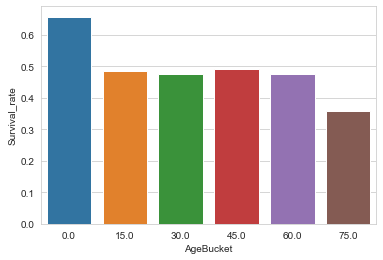

In [33]:
print(survival_rate(train_data, "AgeBucket"))
sns.set_style("whitegrid")
sns.barplot(data=survival_rate(train_data, "AgeBucket").reset_index(),x="AgeBucket",y="Survival_rate")

               Survival_rate
numberInGroup               
1                   0.452445
2                   0.538050
3                   0.593137
4                   0.640777
5                   0.592453
6                   0.614943
7                   0.541126
8                   0.394231


<AxesSubplot:xlabel='numberInGroup', ylabel='Survival_rate'>

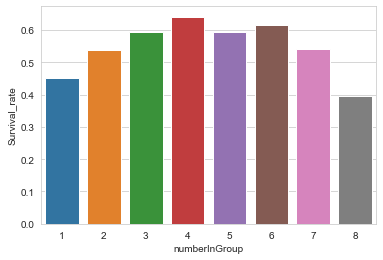

In [34]:
print(survival_rate(train_data, "numberInGroup"))
sns.set_style("whitegrid")
sns.barplot(data=survival_rate(train_data, "numberInGroup").reset_index(),x="numberInGroup",y="Survival_rate")

                 Survival_rate
totalTipsBucket               
0.0                   0.517045
5000.0                0.334118
10000.0               0.336842
15000.0               0.307692
20000.0               0.142857
25000.0               0.250000
30000.0               0.666667
35000.0               0.000000


<AxesSubplot:xlabel='totalTipsBucket', ylabel='Survival_rate'>

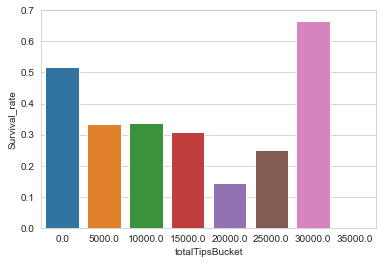

In [35]:
print(survival_rate(train_data, "totalTipsBucket"))
sns.set_style("whitegrid")
sns.barplot(data=survival_rate(train_data, "totalTipsBucket").reset_index(),x="totalTipsBucket",y="Survival_rate")

               Survival_rate
numberInCabin               
1.0                 0.445550
2.0                 0.595481
3.0                 0.611780
4.0                 0.634615
5.0                 0.604255
6.0                 0.631313
7.0                 0.571429
8.0                 0.375000


<AxesSubplot:xlabel='numberInCabin', ylabel='Survival_rate'>

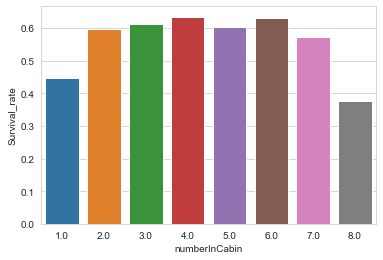

In [36]:
print(survival_rate(train_data, "numberInCabin"))
sns.set_style("whitegrid")
sns.barplot(data=survival_rate(train_data, "numberInCabin").reset_index(),x="numberInCabin",y="Survival_rate")

In [18]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())
    ])

In [19]:
from sklearn.preprocessing import OneHotEncoder
cat_pipeline = Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("cat_encoder", OneHotEncoder()),
    ])

In [20]:
from sklearn.compose import ColumnTransformer
#pour l'instant on n'utilise pas tout, on se contente pour l'instant du plus simple
num_attribs = ["Age","RoomService", "FoodCourt", "ShoppingMall","Spa","VRDeck","totalTips","numberInGroup","numberInCabin"]
cat_attribs = ["HomePlanet", "CryoSleep", "Destination","VIP"]

preprocess_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", cat_pipeline, cat_attribs),
    ])

X_train=train_data.copy()
X_train=X_train.drop(columns=["Transported"])
y_train=train_data["Transported"]



In [21]:
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC

clf = Pipeline(
    steps=[("preprocessor", preprocess_pipeline), ("classifier", SVC(random_state=42))]
)

dt_scores = cross_val_score(clf, X_train, y_train, cv=3)
dt_scores.mean()

0.7822402048588059

In [22]:
from sklearn.ensemble import RandomForestClassifier

clf = Pipeline(
    steps=[("preprocessor", preprocess_pipeline), ("classifier", RandomForestClassifier(random_state=42))]
)

dt_scores = cross_val_score(clf, X_train, y_train, cv=3)
dt_scores.mean()

0.7777530423220868

In [23]:
from sklearn.tree import DecisionTreeClassifier

clf = Pipeline(
    steps=[("preprocessor", preprocess_pipeline), ("classifier", DecisionTreeClassifier(random_state=42))]
)

dt_scores = cross_val_score(clf, X_train, y_train, cv=3)
dt_scores.mean()

0.7166696881244164

In [24]:
from sklearn.neighbors import KNeighborsClassifier

clf = Pipeline(
    steps=[("preprocessor", preprocess_pipeline), ("classifier", KNeighborsClassifier())]
)

dt_scores = cross_val_score(clf, X_train, y_train, cv=3)
dt_scores.mean()

0.7547456937080387

In [25]:
from sklearn.ensemble import BaggingClassifier

clf = Pipeline(
    steps=[("preprocessor", preprocess_pipeline), ("classifier", BaggingClassifier(estimator=SVC(random_state=42), random_state=42))]
)

dt_scores = cross_val_score(clf, X_train, y_train, cv=3)
dt_scores.mean()

0.7831601414693369

In [26]:
from sklearn.ensemble import BaggingClassifier

clf = Pipeline(
    steps=[("preprocessor", preprocess_pipeline), ("classifier", BaggingClassifier(estimator=RandomForestClassifier(random_state=42), random_state=42))]
)

dt_scores = cross_val_score(clf, X_train, y_train, cv=3)
dt_scores.mean()

0.7824694544914864

In [27]:
from sklearn.ensemble import BaggingClassifier

clf = Pipeline(
    steps=[("preprocessor", preprocess_pipeline), ("classifier", BaggingClassifier(estimator=DecisionTreeClassifier(random_state=42), random_state=42))]
)

dt_scores = cross_val_score(clf, X_train, y_train, cv=3)
dt_scores.mean()

0.7633727695110535

In [28]:
from sklearn.ensemble import BaggingClassifier

clf = Pipeline(
    steps=[("preprocessor", preprocess_pipeline), ("classifier", BaggingClassifier(estimator=KNeighborsClassifier(), random_state=42))]
)

dt_scores = cross_val_score(clf, X_train, y_train, cv=3)
dt_scores.mean()

0.7588869569028954

On va maintenant effectuer les mêmes tests mais en changeant les features deck et Side :

In [29]:
from sklearn.compose import ColumnTransformer
#pour l'instant on n'utilise pas tout, on se contente pour l'instant du plus simple
num_attribs = ["Age","RoomService", "FoodCourt", "ShoppingMall","Spa","VRDeck","totalTips","numberInGroup","numberInCabin"]
cat_attribs = ["HomePlanet", "CryoSleep", "Destination","VIP", "Side", "Deck"]

preprocess_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", cat_pipeline, cat_attribs),
    ])

X_train=train_data.copy()
X_train=X_train.drop(columns=["Transported"])
y_train=train_data["Transported"]

In [30]:
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC

clf = Pipeline(
    steps=[("preprocessor", preprocess_pipeline), ("classifier", SVC(random_state=42))]
)

dt_scores = cross_val_score(clf, X_train, y_train, cv=3)
dt_scores.mean()

0.7933992701968569

In [31]:
from sklearn.ensemble import RandomForestClassifier

clf = Pipeline(
    steps=[("preprocessor", preprocess_pipeline), ("classifier", RandomForestClassifier(random_state=42))]
)

dt_scores = cross_val_score(clf, X_train, y_train, cv=3)
dt_scores.mean()

0.7801688585933156

In [32]:
from sklearn.tree import DecisionTreeClassifier

clf = Pipeline(
    steps=[("preprocessor", preprocess_pipeline), ("classifier", DecisionTreeClassifier(random_state=42))]
)

dt_scores = cross_val_score(clf, X_train, y_train, cv=3)
dt_scores.mean()

0.718508687862292

In [33]:
from sklearn.neighbors import KNeighborsClassifier

clf = Pipeline(
    steps=[("preprocessor", preprocess_pipeline), ("classifier", KNeighborsClassifier())]
)

dt_scores = cross_val_score(clf, X_train, y_train, cv=3)
dt_scores.mean()

0.7602676558943161

In [34]:
from sklearn.ensemble import BaggingClassifier

clf = Pipeline(
    steps=[("preprocessor", preprocess_pipeline), ("classifier", BaggingClassifier(estimator=SVC(random_state=42), random_state=42))]
)

dt_scores = cross_val_score(clf, X_train, y_train, cv=3)
dt_scores.mean()

0.79132836067296

In [35]:
from sklearn.ensemble import BaggingClassifier

clf = Pipeline(
    steps=[("preprocessor", preprocess_pipeline), ("classifier", BaggingClassifier(estimator=RandomForestClassifier(random_state=42), random_state=42))]
)

dt_scores = cross_val_score(clf, X_train, y_train, cv=3)
dt_scores.mean()

0.7871864622176039

In [36]:
from sklearn.ensemble import BaggingClassifier

clf = Pipeline(
    steps=[("preprocessor", preprocess_pipeline), ("classifier", BaggingClassifier(estimator=DecisionTreeClassifier(random_state=42), random_state=42))]
)

dt_scores = cross_val_score(clf, X_train, y_train, cv=3)
dt_scores.mean()

0.769355335263096

In [37]:
from sklearn.ensemble import BaggingClassifier

clf = Pipeline(
    steps=[("preprocessor", preprocess_pipeline), ("classifier", BaggingClassifier(estimator=KNeighborsClassifier(), random_state=42))]
)

dt_scores = cross_val_score(clf, X_train, y_train, cv=3)
dt_scores.mean()

0.7607275844958005

On va maintenant ajouter les features AgeBucket et totalTipsBucket :

In [38]:
from sklearn.compose import ColumnTransformer
#pour l'instant on n'utilise pas tout, on se contente pour l'instant du plus simple
num_attribs = ["Age","RoomService", "FoodCourt", "ShoppingMall","Spa","VRDeck","totalTips","numberInGroup","numberInCabin","AgeBucket","totalTipsBucket"]
cat_attribs = ["HomePlanet", "CryoSleep", "Destination","VIP", "Side", "Deck"]

preprocess_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", cat_pipeline, cat_attribs),
    ])

X_train=train_data.copy()
X_train=X_train.drop(columns=["Transported"])
y_train=train_data["Transported"]

In [39]:
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC

clf = Pipeline(
    steps=[("preprocessor", preprocess_pipeline), ("classifier", SVC(random_state=42))]
)

dt_scores = cross_val_score(clf, X_train, y_train, cv=3)
dt_scores.mean()

0.7925939981064473

In [40]:
from sklearn.ensemble import RandomForestClassifier

clf = Pipeline(
    steps=[("preprocessor", preprocess_pipeline), ("classifier", RandomForestClassifier(random_state=42))]
)

dt_scores = cross_val_score(clf, X_train, y_train, cv=3)
dt_scores.mean()

0.7790184415328868

In [41]:
from sklearn.tree import DecisionTreeClassifier

clf = Pipeline(
    steps=[("preprocessor", preprocess_pipeline), ("classifier", DecisionTreeClassifier(random_state=42))]
)

dt_scores = cross_val_score(clf, X_train, y_train, cv=3)
dt_scores.mean()

0.7228804315070466

In [42]:
from sklearn.neighbors import KNeighborsClassifier

clf = Pipeline(
    steps=[("preprocessor", preprocess_pipeline), ("classifier", KNeighborsClassifier())]
)

dt_scores = cross_val_score(clf, X_train, y_train, cv=3)
dt_scores.mean()

0.7584265915598177

In [43]:
from sklearn.ensemble import BaggingClassifier

clf = Pipeline(
    steps=[("preprocessor", preprocess_pipeline), ("classifier", BaggingClassifier(estimator=SVC(random_state=42), random_state=42))]
)

dt_scores = cross_val_score(clf, X_train, y_train, cv=3)
dt_scores.mean()

0.7910983169646554

In [44]:
from sklearn.ensemble import BaggingClassifier

clf = Pipeline(
    steps=[("preprocessor", preprocess_pipeline), ("classifier", BaggingClassifier(estimator=RandomForestClassifier(random_state=42), random_state=42))]
)

dt_scores = cross_val_score(clf, X_train, y_train, cv=3)
dt_scores.mean()

0.7860360848609562

In [45]:
from sklearn.ensemble import BaggingClassifier

clf = Pipeline(
    steps=[("preprocessor", preprocess_pipeline), ("classifier", BaggingClassifier(estimator=DecisionTreeClassifier(random_state=42), random_state=42))]
)

dt_scores = cross_val_score(clf, X_train, y_train, cv=3)
dt_scores.mean()

0.7678598923439913

In [46]:
from sklearn.ensemble import BaggingClassifier

clf = Pipeline(
    steps=[("preprocessor", preprocess_pipeline), ("classifier", BaggingClassifier(estimator=KNeighborsClassifier(), random_state=42))]
)

dt_scores = cross_val_score(clf, X_train, y_train, cv=3)
dt_scores.mean()

0.7584270283014112

On cherche maintenant à optimiser les paramètres du modèle SVM qui est le plus performant

In [47]:
from sklearn.model_selection import RandomizedSearchCV


num_attribs = ["Age","RoomService", "FoodCourt", "ShoppingMall","Spa","VRDeck","totalTips","numberInGroup","numberInCabin"]
cat_attribs = ["HomePlanet", "CryoSleep", "Destination","VIP", "Side", "Deck"]

preprocess_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", cat_pipeline, cat_attribs),
    ])

X_train=train_data.copy()
X_train=X_train.drop(columns=["Transported"])
y_train=train_data["Transported"]

clf = Pipeline(
    steps=[("preprocessor", preprocess_pipeline), ("classifier", SVC(random_state=42))]
)

#on cherche les meilleurs paramètres : 
param_distr = {'classifier__C':range(1, 101),
              'classifier__degree': range(1, 21),
              'classifier__coef0':range(1, 101)}

rnd = RandomizedSearchCV(clf,param_distributions = param_distr, cv = 3, n_iter = 75,
                         scoring = "accuracy", random_state = 42)
rnd.fit(X_train, y_train)

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('scaler',
                                                                                                StandardScaler())]),
                                                                               ['Age',
                                                                                'RoomService',
                                                                                'FoodCourt',
                                                                                'ShoppingMall',
                                                                                'Spa',
                                                                                'VRDeck',
                                                                                'totalTips',
                                                                                'numberInGroup',
                                                                                'numberInCabin']),
                                                                              ('cat',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('cat_encoder',
                                                                                                OneHotEncoder())]),
                                                                               ['HomePlanet',
                                                                                'CryoSleep',
                                                                                'Destination',
                                                                                'VIP',
                                                                                'Side',
                                                                                'Deck'])])),
                                             ('classifier',
                                              SVC(random_state=42))]),
                   n_iter=75,
                   param_distributions={'classifier__C': range(1, 101),
                                        'classifier__coef0': range(1, 101),
                                        'classifier__degree': range(1, 21)},
                   random_state=42, scoring='accuracy')

In [48]:
rnd.best_params_

{'classifier__degree': 8, 'classifier__coef0': 38, 'classifier__C': 2}

In [49]:
rnd.best_score_

0.7946644311849697

In [50]:
clf = rnd.best_estimator_

In [51]:
clf.fit(X_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Age', 'RoomService',
                                                   'FoodCourt', 'ShoppingMall',
                                                   'Spa', 'VRDeck', 'totalTips',
                                                   'numberInGroup',
                                                   'numberInCabin']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('cat_encoder',
                                                                   OneHotEncoder())]),
                                                  ['HomePlanet', 'CryoSleep',
                                                   'Destination', 'VIP', 'Side',
                                                   'Deck'])])),
                ('classifier', SVC(C=2, coef0=38, degree=8, random_state=42))])

In [52]:
y_pred=clf.predict(X_test)

In [53]:
y_pred_df=pd.DataFrame(y_pred, columns = ['Transported'])
y_pred_df=y_pred_df.set_index(X_test["PassengerId"])

In [54]:
y_pred_df.to_csv("C:/Users/miaou/Documents/UTT/ISI-2/PE_IA_RM/Python_script/spaceship_titanic_competition/data/y_pred.csv")

On améliore le modèle existant :

On vérifie dans un premier temps si les personnes d'un même groupe viennet bien de la même planète :

In [55]:
#Create a dataframe containing
group_wise_passenger=train_data[['HomePlanet','group']].groupby(['group']).nunique()
group_wise_passenger.rename(columns={'HomePlanet':'Number_of_home_planets_ingroup'},inplace=True)
print("Nombre de groupe qui ont plus que une homePlanet :",group_wise_passenger[group_wise_passenger['Number_of_home_planets_ingroup']>1].shape[0])

Nombre de groupe qui ont plus que une homePlanet : 0


On remarque que tous le passagers d'un même groupe viennent de la même planète

On vérifie maintenant si l'âge médiant est bien différent en focntion des homePlanet :

  HomePlanet  Median_age_planet
0      Earth               23.0
1     Europa               33.0
2       Mars               28.0


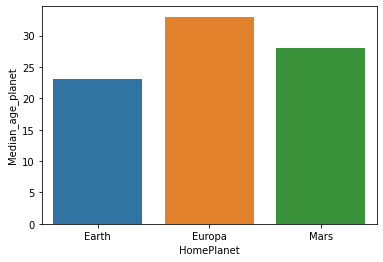

In [56]:
for_filling_age=train_data[['Age','HomePlanet']].groupby(['HomePlanet']).median()
for_filling_age.rename(columns={"Age":"Median_age_planet"},inplace=True)
for_filling_age.reset_index(inplace=True)
sns.barplot(data=for_filling_age,x="HomePlanet",y="Median_age_planet")
print(for_filling_age)

On constate que l'âge médiant est bien différent en fonction des planètes.

On créer maintenant une nouvelle pipeline afin de compléter les données en utilisant les idées du forum

In [58]:
from sklearn.base import BaseEstimator, TransformerMixin
class AdvancedInputer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit( self, X, y = None ):
        return self
# Function to create features and for impute features.
    def transform(self, a, y=None):
        
    #   Create feature to find the homeplanet the other passengers in the group belong to. This is done by first calculating groupwise passengers. In Groups where there are no passengers with Homeplanet, Nan is marked. Later      
        group_wise_passenger=a[['PassengerId','group']].groupby(['group']).count()
        group_wise_passenger.rename(columns={'PassengerId':'Passengers_in_group'},inplace=True)
        group_wise_mf_planet=a[['HomePlanet','group']].groupby(['group']).agg(lambda x: x.value_counts().index[0] if x.value_counts().size>0 else float("Nan"))
        a=pd.merge(a,group_wise_passenger,how='left',left_on='group',right_index=True)
        group_wise_mf_planet.rename(columns={'HomePlanet':'Top_planet_in_group'},inplace=True)
        a=pd.merge(a,group_wise_mf_planet,how='left',left_on='group',right_index=True)
        a.loc[(a['HomePlanet'].isna())&(a['Passengers_in_group']>1),'HomePlanet']=a[(a['HomePlanet'].isna())&(a['Passengers_in_group']>1)]['Top_planet_in_group']
        
    #   Create a dataframe for HomePlanet wise median age and use it to impute age where it is missing  
        for_filling_age=a[['Age','HomePlanet']].groupby(['HomePlanet']).median()
        for_filling_age.rename(columns={"Age":"Median_age_planet"},inplace=True)
        a=pd.merge(a,for_filling_age,how="left",left_on="HomePlanet",right_index=True)
        a.loc[(~ a['HomePlanet'].isna())&(a['Age'].isna()),'Age']=a[(~a['HomePlanet'].isna())&(a['Age'].isna())]['Median_age_planet']
        a.drop(columns=['Top_planet_in_group', 'Median_age_planet','Passengers_in_group'],inplace=True)
        a.drop(columns=['Cabin','PassengerId'],inplace=True)
        return a

In [59]:
clf = Pipeline(
    steps=[("HomePlanetAgeInputer",AdvancedInputer()),("preprocessor", preprocess_pipeline), ("classifier", SVC(random_state=42))]
)

dt_scores = cross_val_score(clf, X_train, y_train, cv=3)
dt_scores.mean()

0.7936292742013803

In [60]:
clf = Pipeline(
    steps=[("HomePlanetAgeInputer",AdvancedInputer()),("preprocessor", preprocess_pipeline), ("classifier", BaggingClassifier(estimator=SVC(random_state=42), random_state=42))]
)

dt_scores = cross_val_score(clf, X_train, y_train, cv=3)
dt_scores.mean()

0.791443541342237

In [66]:
num_attribs = ["Age","RoomService", "FoodCourt", "ShoppingMall","Spa","VRDeck","totalTips","numberInGroup","numberInCabin"]
cat_attribs = ["HomePlanet", "CryoSleep", "Destination","VIP", "Side", "Deck"]

preprocess_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", cat_pipeline, cat_attribs),
    ])

X_train=train_data.copy()
X_train=X_train.drop(columns=["Transported"])
y_train=train_data["Transported"]

clf = Pipeline(
    steps=[("HomePlanetAgeInputer",AdvancedInputer()), ("preprocessor", preprocess_pipeline), ("classifier", SVC(random_state=42))]
)

#on cherche les meilleurs paramètres : 
param_distr = {'classifier__C':range(1, 101),
              'classifier__degree': range(1, 21),
              'classifier__coef0':range(1, 101)}

rnd = RandomizedSearchCV(clf,param_distributions = param_distr, cv = 3, n_iter = 75,
                         scoring = "accuracy", random_state = 42)
rnd.fit(X_train, y_train)

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('HomePlanetAgeInputer',
                                              AdvancedInputer()),
                                             ('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('scaler',
                                                                                                StandardScaler())]),
                                                                               ['Age',
                                                                                'RoomService',
                                                                                'FoodCourt',
                                                                                'ShoppingMall',
                                                                                'Spa',
                                                                                'VRDeck',
                                                                                'totalTips',
                                                                                'numberInGroup',
                                                                                'numberInCabin']),
                                                                              ('...
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('cat_encoder',
                                                                                                OneHotEncoder())]),
                                                                               ['HomePlanet',
                                                                                'CryoSleep',
                                                                                'Destination',
                                                                                'VIP',
                                                                                'Side',
                                                                                'Deck'])])),
                                             ('classifier',
                                              SVC(random_state=42))]),
                   n_iter=75,
                   param_distributions={'classifier__C': range(1, 101),
                                        'classifier__coef0': range(1, 101),
                                        'classifier__degree': range(1, 21)},
                   random_state=42, scoring='accuracy')

In [67]:
rnd.best_params_

{'classifier__degree': 8, 'classifier__coef0': 38, 'classifier__C': 2}

In [68]:
rnd.best_score_ 0.7946644311849697

0.7946643517774072

In [69]:
clf=rnd.best_estimator_

In [70]:
clf.fit(X_train,y_train)

Pipeline(steps=[('HomePlanetAgeInputer', AdvancedInputer()),
                ('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Age', 'RoomService',
                                                   'FoodCourt', 'ShoppingMall',
                                                   'Spa', 'VRDeck', 'totalTips',
                                                   'numberInGroup',
                                                   'numberInCabin']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('cat_encoder',
                                                                   OneHotEncoder())]),
                                                  ['HomePlanet', 'CryoSleep',
                                                   'Destination', 'VIP', 'Side',
                                                   'Deck'])])),
                ('classifier', SVC(C=2, coef0=38, degree=8, random_state=42))])

In [71]:
y_pred=clf.predict(X_test)

In [72]:
y_pred_df=pd.DataFrame(y_pred, columns = ['Transported'])
y_pred_df=y_pred_df.set_index(X_test["PassengerId"])

In [73]:
y_pred_df.to_csv("C:/Users/miaou/Documents/UTT/ISI-2/PE_IA_RM/Python_script/spaceship_titanic_competition/data/y_pred.csv")